In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def sweep_method(n, A, B, C, F):
    ac = A.copy().astype(float)
    bc = B.copy().astype(float)
    cc = C.copy().astype(float)
    fc = F.copy().astype(float)

    for i in range(1, n):
        w = ac[i] / cc[i-1]
        cc[i] = cc[i] - w * bc[i-1]
        fc[i] = fc[i] - w * fc[i-1]

    y = np.zeros(n)
    y[-1] = fc[-1] / cc[-1]
    for i in range(n-2, -1, -1):
        y[i] = (fc[i] - bc[i] * y[i+1]) / cc[i]

    return y

In [3]:
def heat_equation(L, T, Nx, Nt, F_func=None, u0_func=None, m1_func=None, m2_func=None, sigma=0.5):

    h = L / Nx
    tau = T / Nt
    x = np.linspace(0, L, Nx+1)
    t = np.linspace(0, T, Nt+1)
    
    u = np.zeros((Nt+1, Nx+1))

    if u0_func:
        u[0, :] = [u0_func(xi) for xi in x]

    if m1_func is None: m1_func = lambda t: 0.0
    if m2_func is None: m2_func = lambda t: 0.0
    u[:, 0] = [m1_func(ti) for ti in t]
    u[:, -1] = [m2_func(ti) for ti in t]
    
    n = Nx - 1

    for m in range(1, Nt+1):
        A = np.zeros(n)
        B = np.zeros(n)
        C = np.zeros(n)
        F_vec = np.zeros(n)
    
        for i in range(n):
            C[i] = 1.0 + 2.0 * sigma * tau / h**2
            if i > 0:
                A[i] = - sigma * tau / h**2
            else:
                A[i] = 0.0
            if i < n - 1:
                B[i] = - sigma * tau / h**2
            else:
                B[i] = 0.0
    
            laplace_prev = (u[m-1, i+2] - 2.0 * u[m-1, i+1] + u[m-1, i]) / h**2
            F_val = F_func(x[i+1], t[m]) if F_func else 0.0
            F_vec[i] = u[m-1, i+1] + tau * ((1.0 - sigma) * laplace_prev + F_val)
    
        # Для Дирихле: a[0]=0, b[n-1]=0, и просто передаём массивы в sweep
        u[m, 1:Nx] = sweep_method(n, A, B, C, F_vec)
    
    return x, t, u

In [4]:
def compare_sigmas(sigmas, L, T, Nx, F_func, u0_func, m1_func, m2_func):
    results = {}
    x = None
    tgrid = None
    for sigma, Nt_sigma in sigmas:
        x, t, u = heat_equation(L=L, T=T, Nx=Nx, Nt=Nt_sigma, F_func=F_func, u0_func=u0_func, m1_func=m1_func, m2_func=m2_func, sigma=sigma)
        results[sigma] = u
        tgrid = t
    return x, tgrid, results

C:\Users\Mishele Dolmin\AppData\Local\Temp\ipykernel_20596\494027198.py:37: RuntimeWarning: overflow encountered in scalar divide
  laplace_prev = (u[m-1, i+2] - 2.0 * u[m-1, i+1] + u[m-1, i]) / h**2
C:\Users\Mishele Dolmin\AppData\Local\Temp\ipykernel_20596\3246397363.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  fc[i] = fc[i] - w * fc[i-1]



Ошибки численного метода относительно аналитического решения (t=T):
              L∞ ошибка     L2 ошибка
sigma=0             NaN           NaN
sigma=0.5  3.268582e-45  2.288465e-45
sigma=1.0  5.555569e-43  3.889676e-43


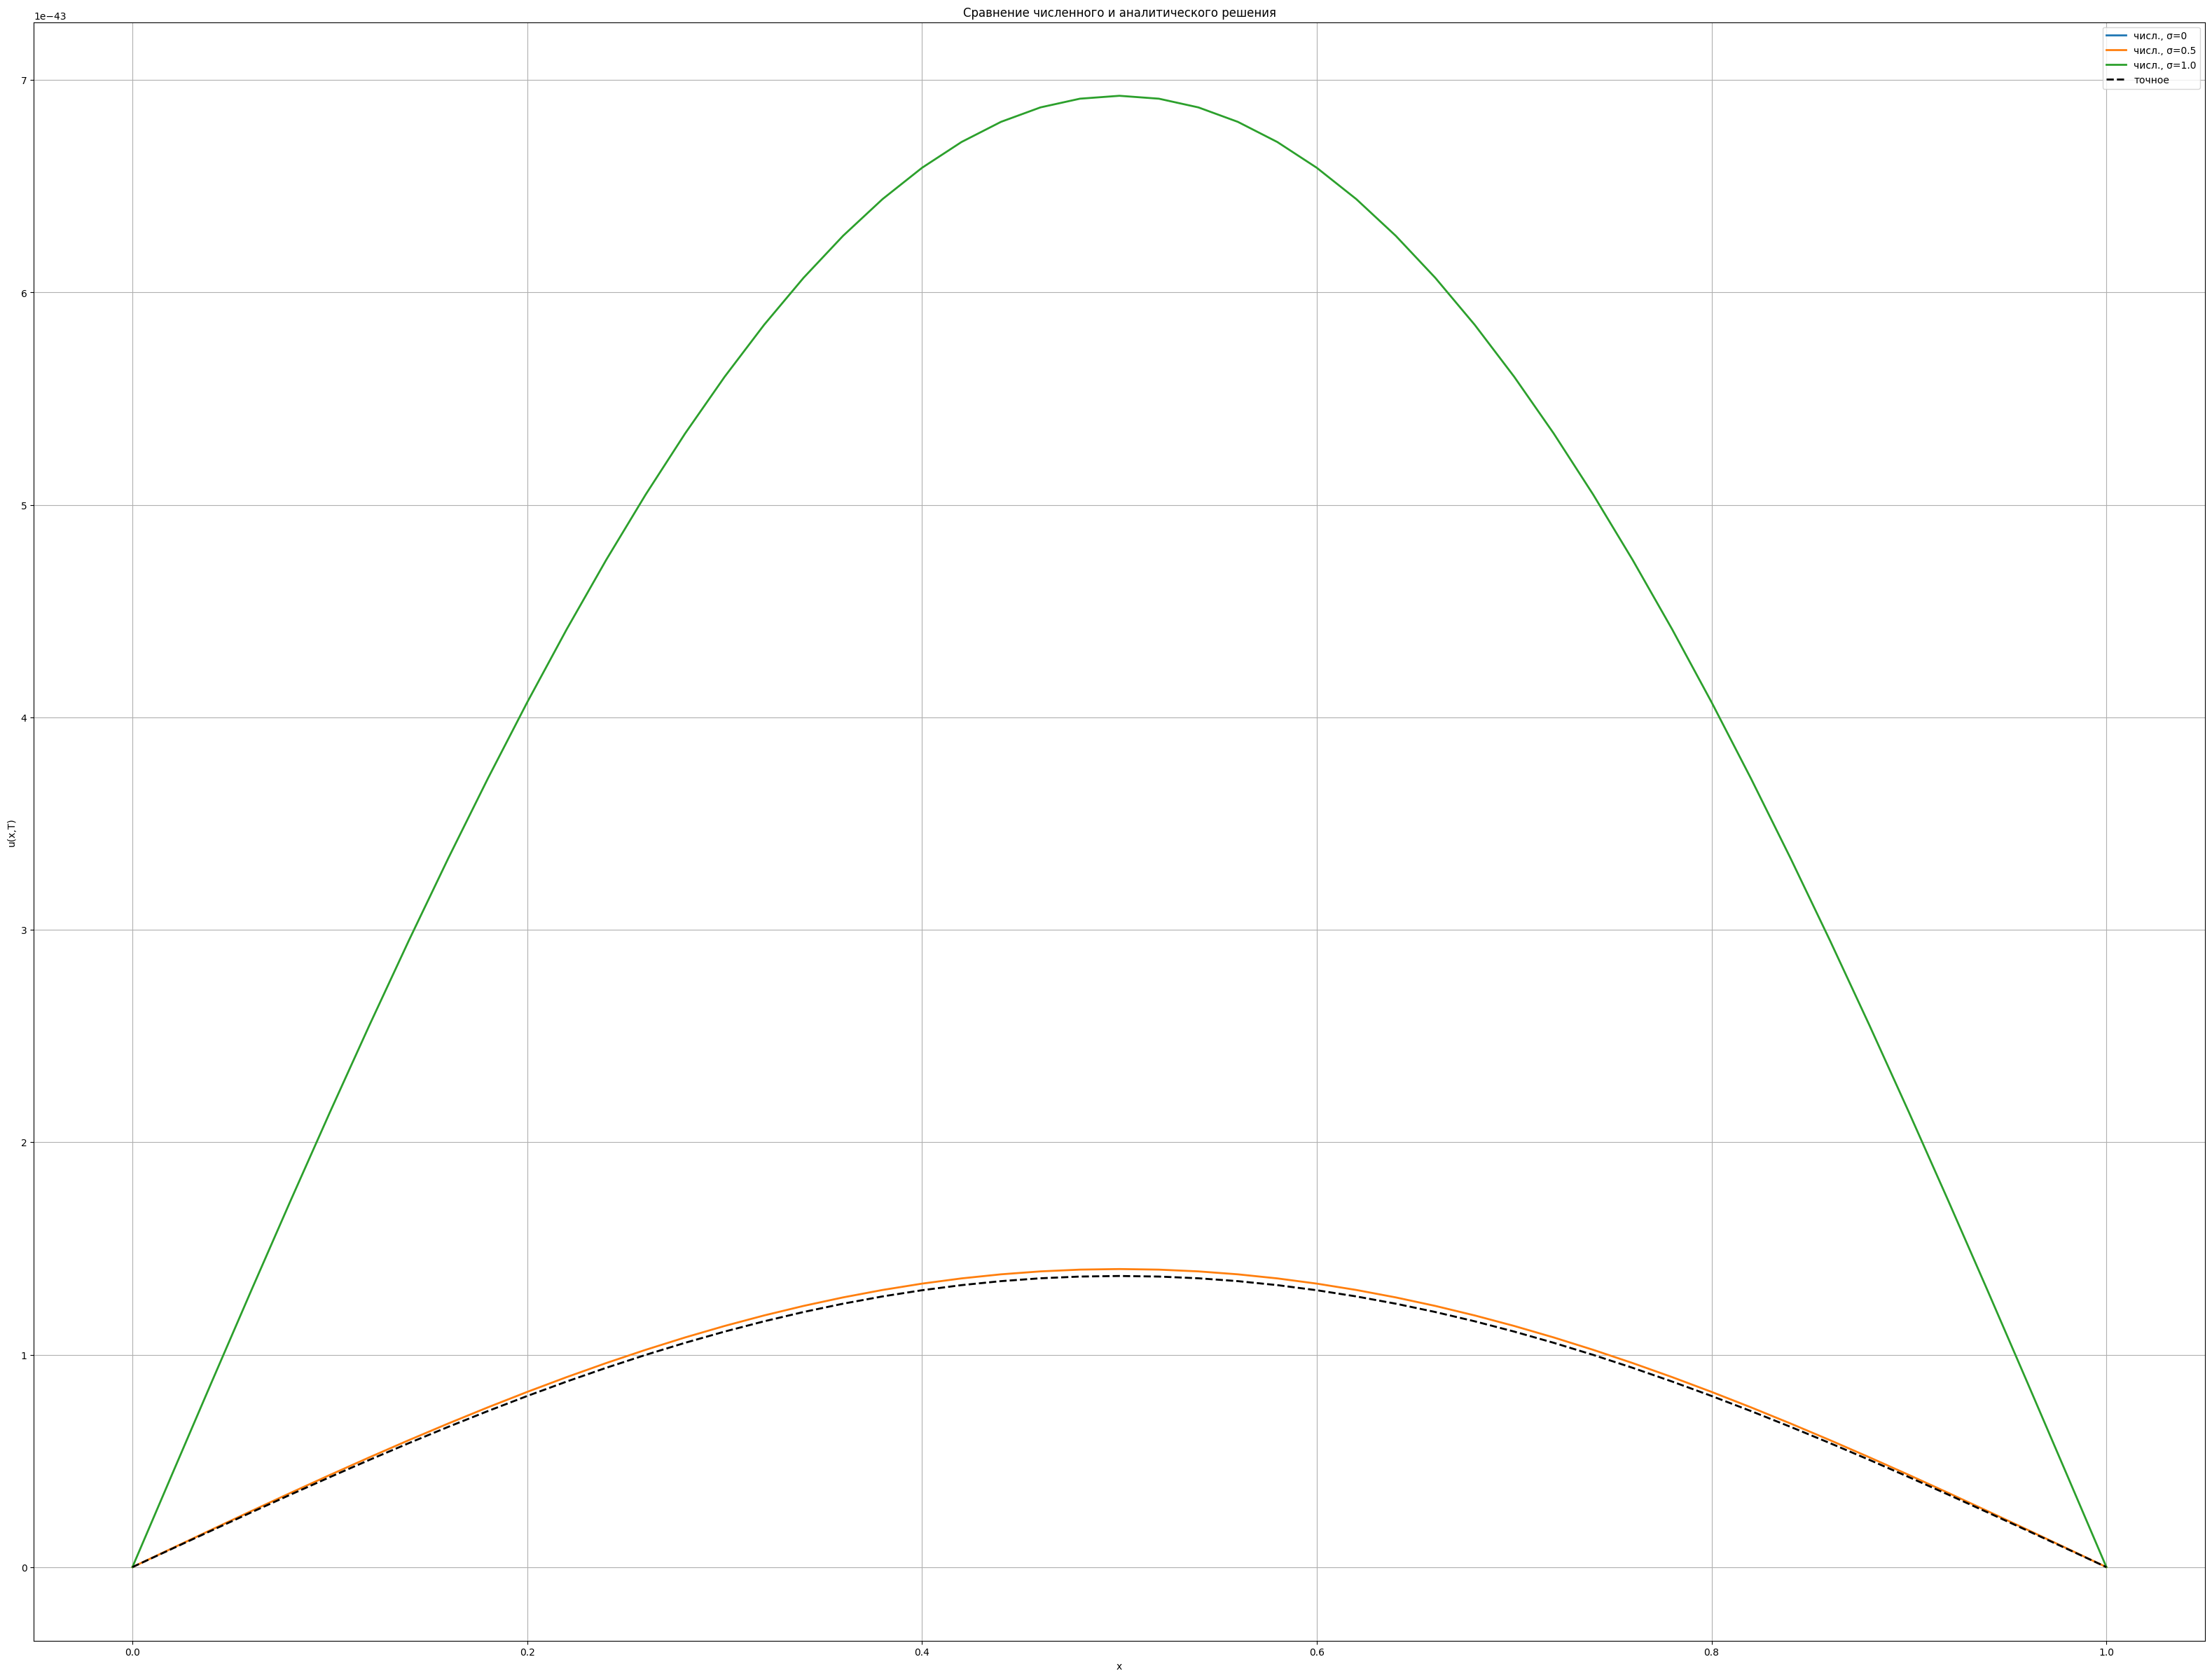

In [9]:
L = 1.0
T = 10
Nx = 50
sigma_values = [(0, 3000), (0.5, 3000), (1.0, 3000)]

F_func = lambda x,t: 0.0
u0_func = lambda x: np.sin(np.pi * x)
m1_func = lambda t: 0.0
m2_func = lambda t: 0.0

u_exact = lambda x, t: np.sin(np.pi * x) * np.exp(- (np.pi**2) * t)

x, tgrid, results = compare_sigmas(sigma_values, L, T, Nx, F_func, u0_func, m1_func, m2_func)

exact_T = u_exact(x, T)
error_data = {}
for sigma, U in results.items():
    num_T = U[-1]
    err = num_T - exact_T
    error_data[f"sigma={sigma}"] = {"L∞ ошибка": np.max(np.abs(err)),
                                    "L2 ошибка": np.sqrt(np.mean(err**2))}

df_err = pd.DataFrame(error_data).T
print("\nОшибки численного метода относительно аналитического решения (t=T):")
print(df_err)

plt.figure(figsize=(40,30))
linestyles = {0:'-', 0.5:'-', 1:'-'}
for sigma, U in results.items():
    plt.plot(x, U[-1], linestyles[sigma], lw=2, ms=5, label=f"числ., σ={sigma}")
plt.plot(x, exact_T, 'k--', lw=2, label="точное")
plt.xlabel("x"); plt.ylabel("u(x,T)")
plt.title(f"Сравнение численного и аналитического решения")
plt.legend(); plt.grid(True)
plt.show()


Ошибки численного метода относительно аналитического решения (t=T):
           L∞ ошибка  L2 ошибка
sigma=0.0   0.000006   0.000004
sigma=0.5   0.000003   0.000002
sigma=1.0   0.000032   0.000023


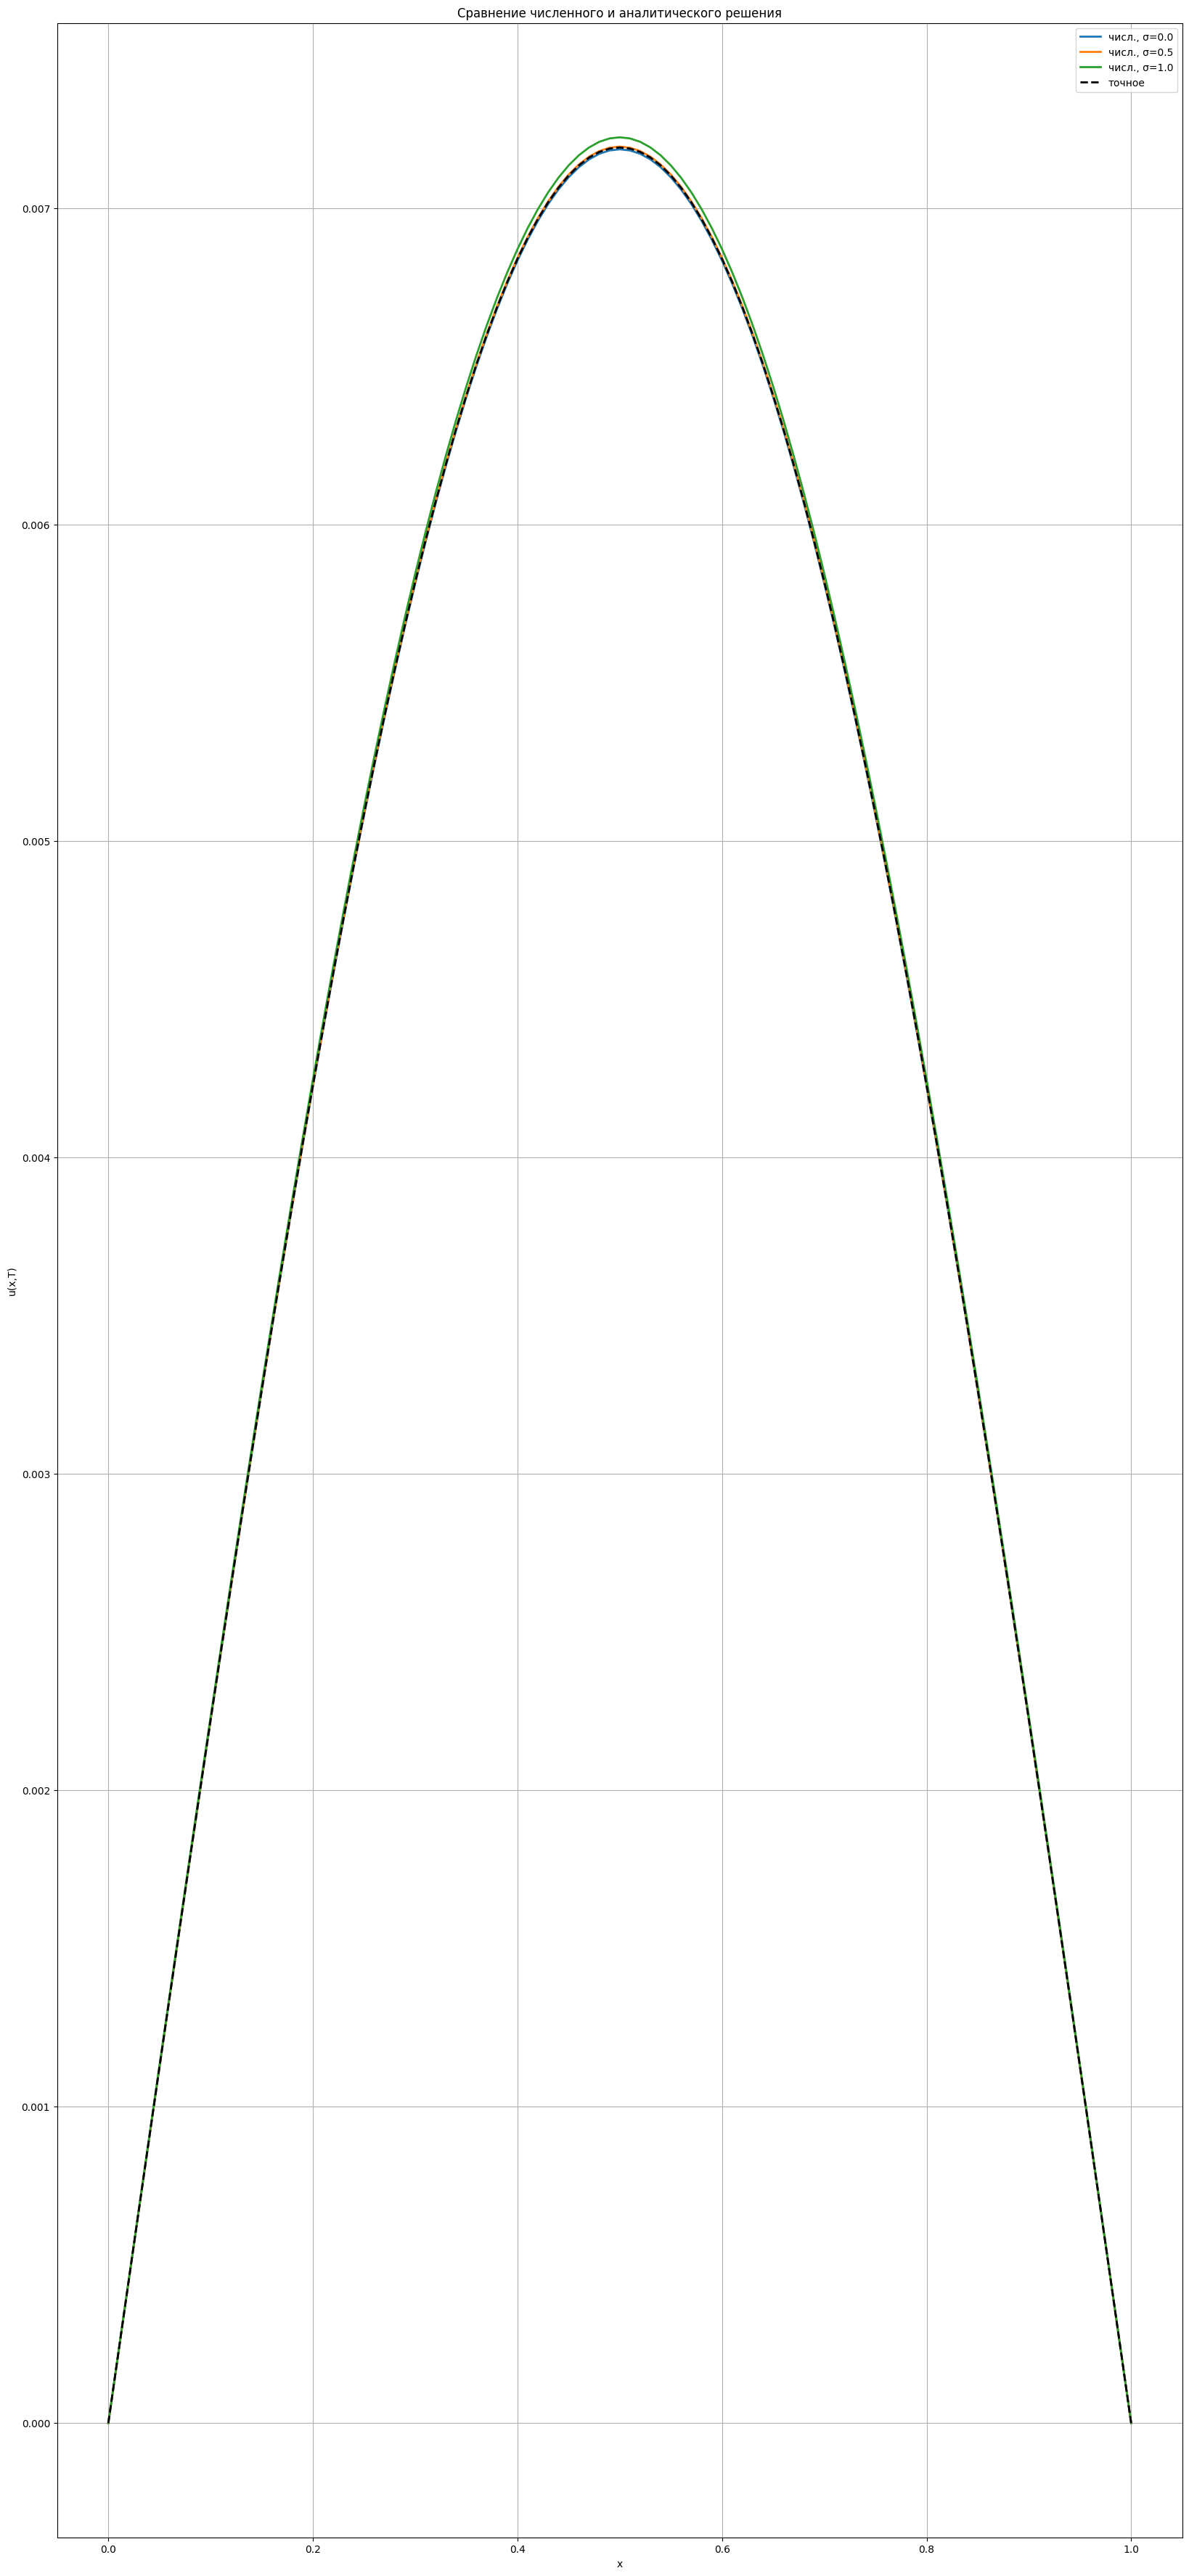

In [6]:
L = 1.0
T = 0.5
Nx = 100
sigma_values = [(0.0, 10000), (0.5, 3000), (1.0, 3000)]

F_func = lambda x,t: 0.0
u0_func = lambda x: np.sin(np.pi * x)
m1_func = lambda t: 0.0
m2_func = lambda t: 0.0

u_exact = lambda x, t: np.sin(np.pi * x) * np.exp(- (np.pi**2) * t)

x, tgrid, results = compare_sigmas(sigma_values, L, T, Nx, F_func, u0_func, m1_func, m2_func)

exact_T = u_exact(x, T)
error_data = {}
for sigma, U in results.items():
    num_T = U[-1]
    err = num_T - exact_T
    error_data[f"sigma={sigma}"] = {"L∞ ошибка": np.max(np.abs(err)),
                                    "L2 ошибка": np.sqrt(np.mean(err**2))}

df_err = pd.DataFrame(error_data).T
print("\nОшибки численного метода относительно аналитического решения (t=T):")
print(df_err)

plt.figure(figsize=(20, 45))
linestyles = {0:'-', 0.5:'-', 1:'-'}
for sigma, U in results.items():
    plt.plot(x, U[-1], linestyles[sigma], lw=2, ms=5, label=f"числ., σ={sigma}")
plt.plot(x, exact_T, 'k--', lw=2, label="точное")
plt.xlabel("x"); plt.ylabel("u(x,T)")
plt.title(f"Сравнение численного и аналитического решения")
plt.legend(); plt.grid(True)
plt.show()

C:\Users\Mishele Dolmin\AppData\Local\Temp\ipykernel_20596\494027198.py:37: RuntimeWarning: overflow encountered in scalar divide
  laplace_prev = (u[m-1, i+2] - 2.0 * u[m-1, i+1] + u[m-1, i]) / h**2
C:\Users\Mishele Dolmin\AppData\Local\Temp\ipykernel_20596\3246397363.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  fc[i] = fc[i] - w * fc[i-1]



Ошибки численного метода относительно аналитического решения (t=T):
              L∞ ошибка     L2 ошибка
sigma=0             NaN           NaN
sigma=0.5  1.087573e-07  7.682626e-08
sigma=1.0  2.933404e-05  2.072159e-05


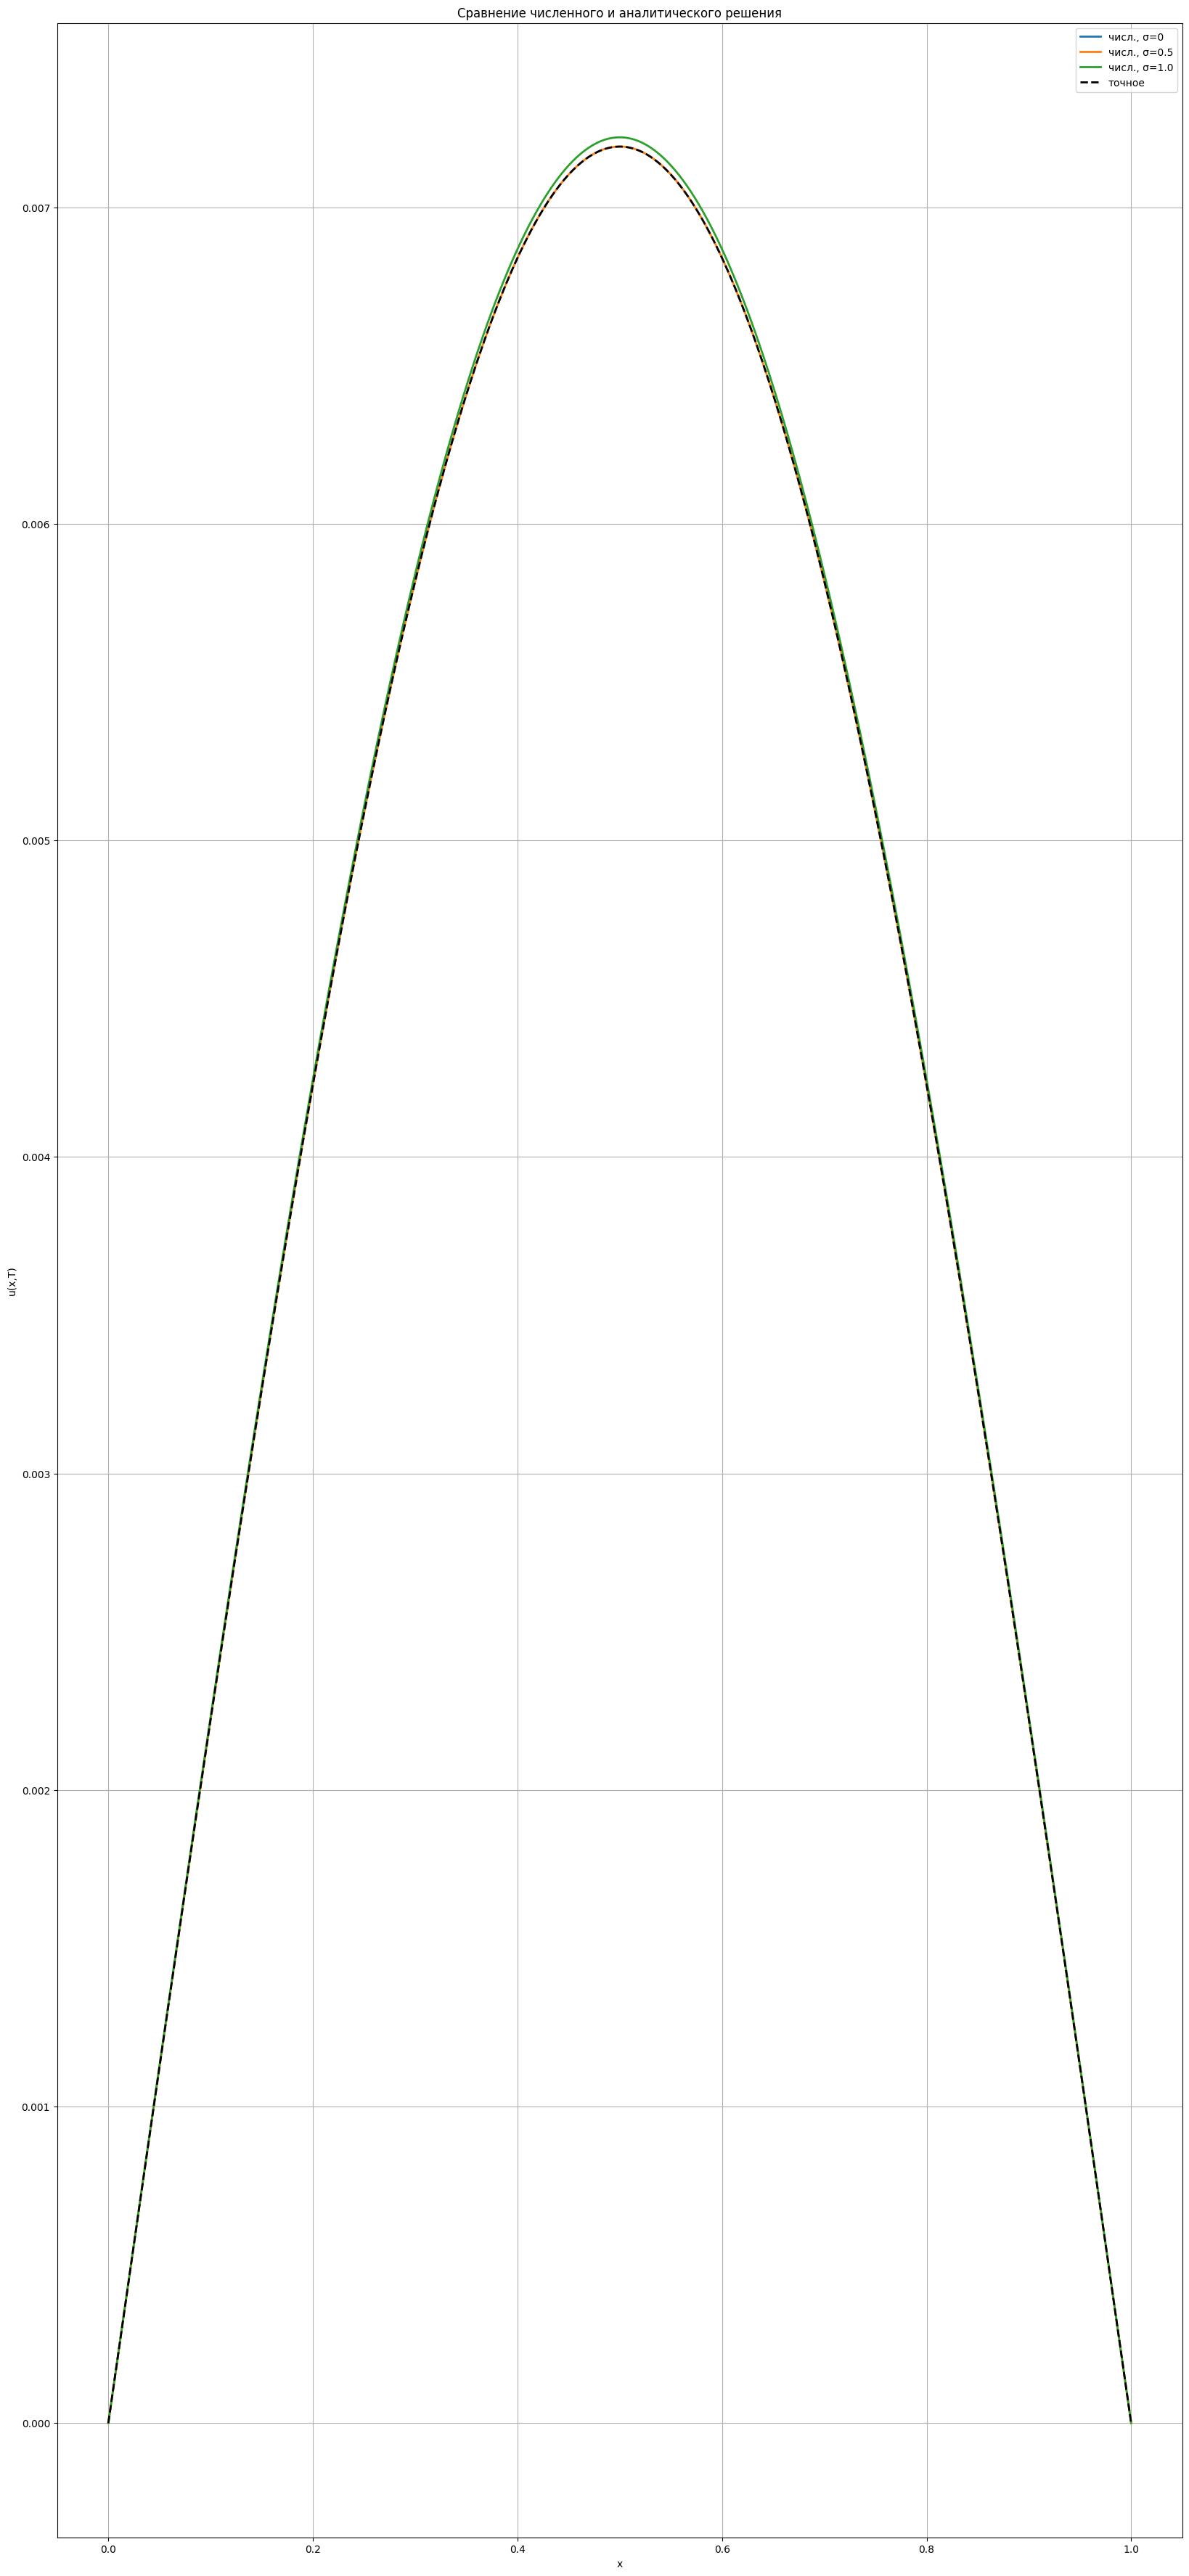

In [7]:
L = 1.0
T = 0.5
Nx = 500
sigma_values = [(0, 3000), (0.5, 3000), (1.0, 3000)]

F_func = lambda x,t: 0.0
u0_func = lambda x: np.sin(np.pi * x)
m1_func = lambda t: 0.0
m2_func = lambda t: 0.0

u_exact = lambda x, t: np.sin(np.pi * x) * np.exp(- (np.pi**2) * t)

x, tgrid, results = compare_sigmas(sigma_values, L, T, Nx, F_func, u0_func, m1_func, m2_func)

exact_T = u_exact(x, T)
error_data = {}
for sigma, U in results.items():
    num_T = U[-1]
    err = num_T - exact_T
    error_data[f"sigma={sigma}"] = {"L∞ ошибка": np.max(np.abs(err)),
                                    "L2 ошибка": np.sqrt(np.mean(err**2))}

df_err = pd.DataFrame(error_data).T
print("\nОшибки численного метода относительно аналитического решения (t=T):")
print(df_err)

plt.figure(figsize=(20, 45))
linestyles = {0:'-', 0.5:'-', 1:'-'}
for sigma, U in results.items():
    plt.plot(x, U[-1], linestyles[sigma], lw=2, ms=5, label=f"числ., σ={sigma}")
plt.plot(x, exact_T, 'k--', lw=2, label="точное")
plt.xlabel("x"); plt.ylabel("u(x,T)")
plt.title(f"Сравнение численного и аналитического решения")
plt.legend(); plt.grid(True)
plt.show()


Ошибки численного метода относительно аналитического решения (t=T):
           L∞ ошибка  L2 ошибка
sigma=0.0   0.000003   0.000002
sigma=0.5   0.000012   0.000008
sigma=1.0   0.000041   0.000029


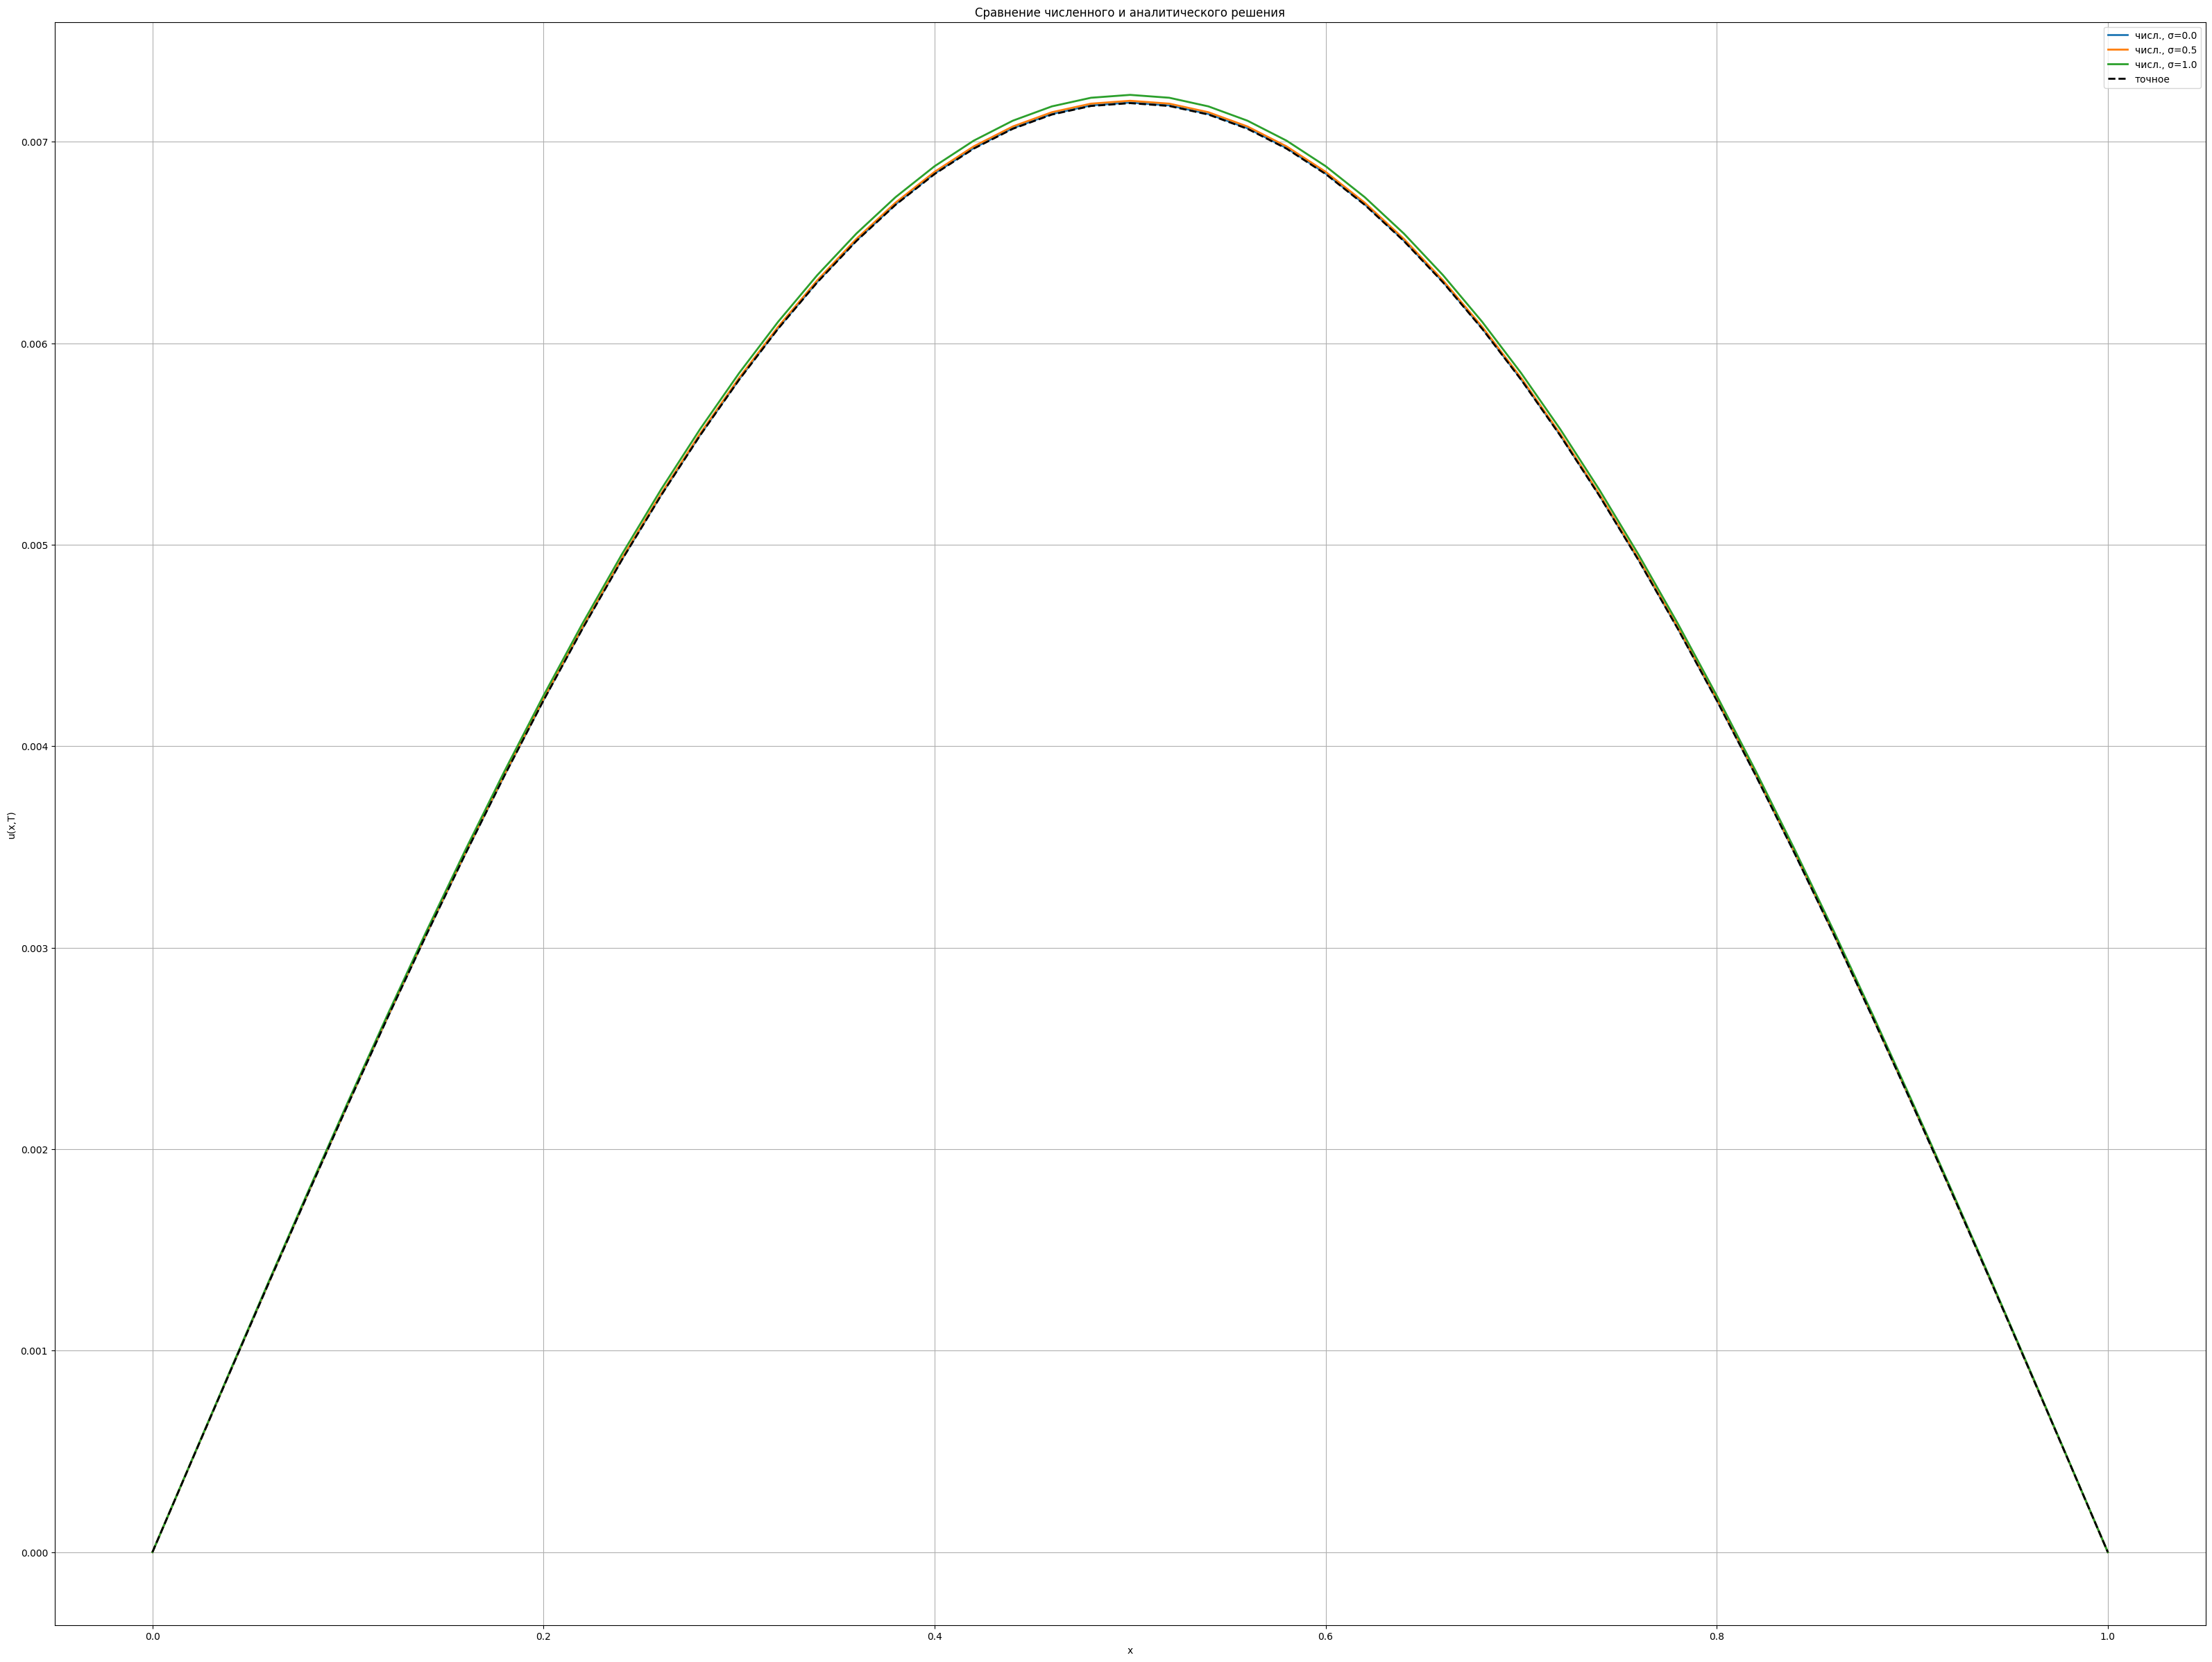

In [8]:
L = 1.0
T = 0.5
Nx = 50
sigma_values = [(0.0, 10000), (0.5, 3000), (1.0, 3000)]

F_func = lambda x,t: 0.0
u0_func = lambda x: np.sin(np.pi * x)
m1_func = lambda t: 0.0
m2_func = lambda t: 0.0

u_exact = lambda x, t: np.sin(np.pi * x) * np.exp(- (np.pi**2) * t)

x, tgrid, results = compare_sigmas(sigma_values, L, T, Nx, F_func, u0_func, m1_func, m2_func)

exact_T = u_exact(x, T)
error_data = {}
for sigma, U in results.items():
    num_T = U[-1]
    err = num_T - exact_T
    error_data[f"sigma={sigma}"] = {"L∞ ошибка": np.max(np.abs(err)),
                                    "L2 ошибка": np.sqrt(np.mean(err**2))}

df_err = pd.DataFrame(error_data).T
print("\nОшибки численного метода относительно аналитического решения (t=T):")
print(df_err)

plt.figure(figsize=(40,30))
linestyles = {0:'-', 0.5:'-', 1:'-'}
for sigma, U in results.items():
    plt.plot(x, U[-1], linestyles[sigma], lw=2, ms=5, label=f"числ., σ={sigma}")
plt.plot(x, exact_T, 'k--', lw=2, label="точное")
plt.xlabel("x"); plt.ylabel("u(x,T)")
plt.title(f"Сравнение численного и аналитического решения")
plt.legend(); plt.grid(True)
plt.show()